In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import json
import argparse
import copy

import torch

from model import my_flow_model, MyDataset
from matplotlib.colors import LogNorm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

opt:  Namespace(output_dir='./output', seed=12345, data_dir='../TNG_data', train_ratio=0.9, batch_size=1024, num_epochs=30, lr=0.001, use_sampler=True, hidden_dim=64, num_layers=2, num_features_in=2, num_features_out=2, norm_params=[[11.0, 15.0], [-1.2, 3.0], [-2.0, 1.0], [-4.0, 4.0], [0.5, 3.5]])


Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): RandomPermutation()
      (1): AffineCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=3, out_features=64, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x ResidualBlock(
              (activation): ReLU()
              (context_layer): Linear(in_features=2, out_features=64, bias=True)
              (linear_layers): ModuleList(
                (0-1): 2 x Linear(in_features=64, out_features=64, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): Linear(in_features=64, out_features=2, bias=True)
        )
      )
      (2): RandomPermutation()
      (3): AffineCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=3, out_features=64, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x ResidualBlo

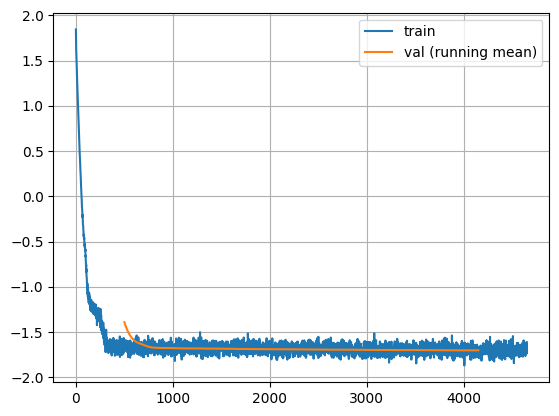

In [5]:
model_dir = "./output"

### plot loss 
loss = np.loadtxt(f"{model_dir}/log.txt", comments="#")
plt.figure()
plt.plot(loss[:,0], label="train")

def running_mean(x, window_size):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[window_size:] - cumsum[:-window_size]) / window_size

loss_val = running_mean(loss[:,1], 1000)
xx = np.arange(len(loss_val)) + 500
plt.plot(xx, loss_val, label="val (running mean)")
plt.grid()
plt.legend()
#plt.yscale("log")
#plt.ylim([-1, -0.7])

### load parameters
with open(f"{model_dir}/args.json", "r") as f:
    opt = json.load(f, object_hook=lambda d: argparse.Namespace(**d))
print("opt: ", opt)

norm_params = np.loadtxt("../norm_params.txt")

### load model
model = my_flow_model(opt)
model.to(device)
#print(model)

model.load_state_dict(torch.load(f"{model_dir}/model.pth"))
model.eval()


In [6]:
### True data ###
dataset_true = MyDataset(f"../TNG_data", norm_params=norm_params)
x_true = dataset_true.x
y_true = dataset_true.y

### model output ###
count = 0
generated = []
while count < len(x_true):
    tmp = x_true[count:count+opt.batch_size].to(device)
    gen = model.sample(num_samples=1, context=tmp).squeeze(1)
    generated.append(gen)
    count += opt.batch_size
generated = torch.cat(generated, dim=0)

x_true = x_true.detach().cpu().numpy() # (batch, num_condition) -> (batch,)
y_true = y_true.detach().cpu().numpy()
generated = generated.detach().cpu().numpy()

In [7]:
### binning ###
nbins = 20
logm_bins = np.linspace(0, 1, nbins+1)
logm_bin_indices_true = np.digitize(x_true, logm_bins) - 1 # (num_samples,)

y_bins = np.linspace(0, 1, nbins+1)
y_bin_indices_true = np.digitize(y_true, y_bins) - 1 # (num_samples, seq_length, num_params)
y_bin_indices_generated = np.digitize(generated, y_bins) - 1 # (num_samples, seq_length, num_params)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(100, 100)),
 array([-0.33085927, -0.31617573, -0.30149218, -0.28680864, -0.2721251 ,
        -0.25744158, -0.24275802, -0.22807449, -0.21339095, -0.1987074 ,
        -0.18402386, -0.16934031, -0.15465677, -0.13997322, -0.1252897 ,
        -0.11060615, -0.0959226 , -0.08123906, -0.06655553, -0.05187199,
        -0.03718844, -0.0225049 , -0.00782135,  0.00686219,  0.02154574,
         0.03622928,  0.05091283,  0.06559634,  0.08027989,  0.09496343,
         0.10964698,  0.12433052,  0.13901407,  0.15369761,  0.16838115,
         0.18306467,  0.19774821,  0.21243176,  0.2271153 ,  0.24179885,
         0.2564824 ,  0.27116594,  0.28584948,  0.30053303,  0.31521657,
         0.32990012,  0.34458366,  0.3592672 ,  0.37395075,  0.3886343 ,
   

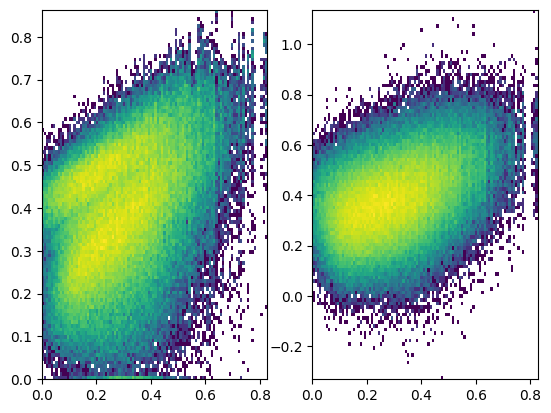

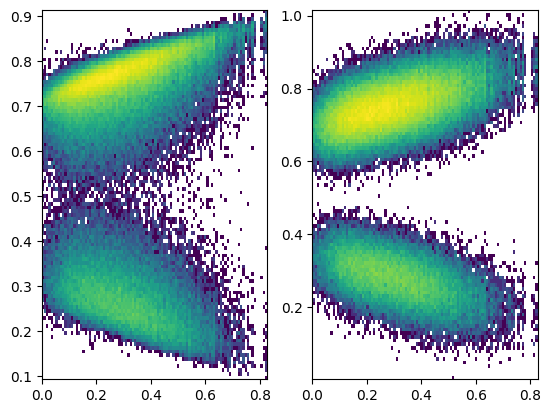

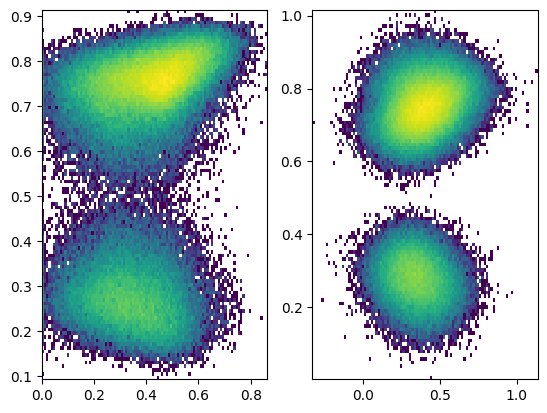

In [10]:
for i in range(1):
    for j in range(2):
        plt.figure()
        plt.subplot(121)
        hist2d = plt.hist2d(x_true[:,i], y_true[:,j], bins=100, norm=LogNorm())
        plt.subplot(122)
        hist2d = plt.hist2d(x_true[:,i], generated[:,j], bins=100, norm=LogNorm())
        #plt.scatter(x_true[:,0], generated[:,0], s=1)


plt.figure()
plt.subplot(121)
plt.hist2d(y_true[:,0], y_true[:,1], bins=100, norm=LogNorm())
plt.subplot(122)
plt.hist2d(generated[:,0], generated[:,1], bins=100, norm=LogNorm())
